In [1]:
from prophet import Prophet
import pandas as pd
from matplotlib import pyplot as plt
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('numexpr').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('../examples/example_wp_log_peyton_manning.csv')

You may have noticed in the earlier examples in this documentation that real time series frequently have abrupt changes in their trajectories. By default, Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately. However, if you wish to have finer control over this process (e.g., Prophet missed a rate change, or is overfitting rate changes in the history), then there are several input arguments you can use.

### Automatic changepoint detection in Prophet
Prophet detects changepoints by first specifying a large number of *potential changepoints* at which the rate is allowed to change. It then puts a sparse prior on the magnitudes of the rate changes (equivalent to L1 regularization) - this essentially means that Prophet has a large number of *possible* places where the rate can change, but will use as few of them as possible. Consider the Peyton Manning forecast from the Quickstart. By default, Prophet specifies 25 potential changepoints which are uniformly placed in the first 80% of the time series. The vertical lines in this figure indicate where the potential changepoints were placed:

Initial log joint probability = -19.4685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7975.31    0.00415855       247.015      0.7831      0.7831      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7994.53      0.010249        344.02           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       7995.33   5.91718e-05       165.006   4.517e-07       0.001      316  LS failed, Hessian reset 
     299       7997.26   0.000813407       209.659       6.754      0.6754      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        8001.1   0.000792021       147.659      0.5991           1      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     488       8002.21   7.22552e-05    

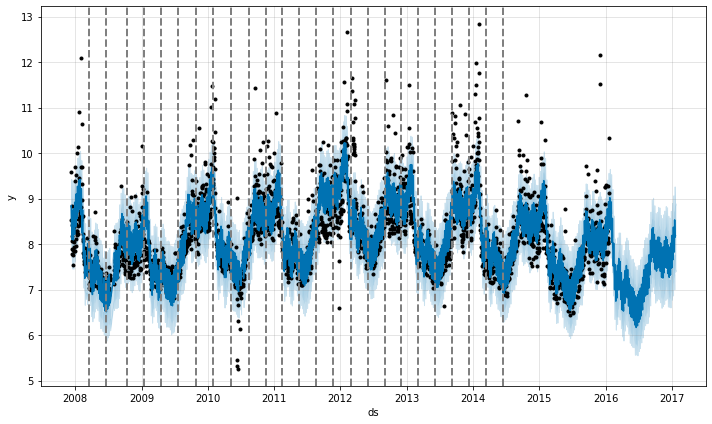

In [2]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=366)
forecast = m.predict(future)
fig = m.plot(forecast)
for cp in m.changepoints:
    plt.axvline(cp, c='gray', ls='--', lw=2)

Even though we have a lot of places where the rate can possibly change, because of the sparse prior, most of these changepoints go unused. We can see this by plotting the magnitude of the rate change at each changepoint:

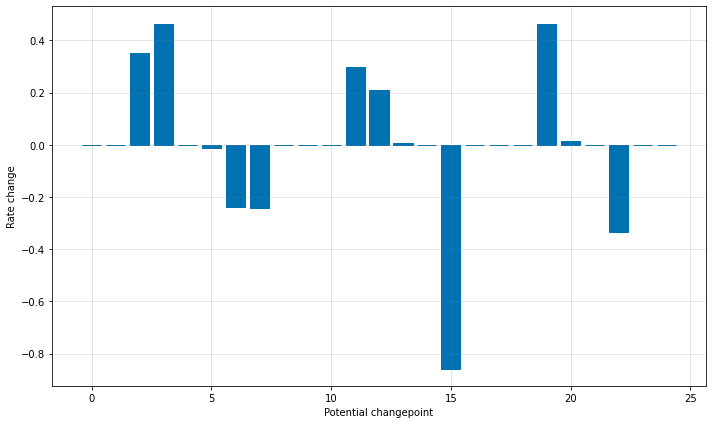

In [3]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0072B2', edgecolor='#0072B2')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

The number of potential changepoints can be set using the argument `n_changepoints`, but this is better tuned by adjusting the regularization. The locations of the signification changepoints can be visualized with:

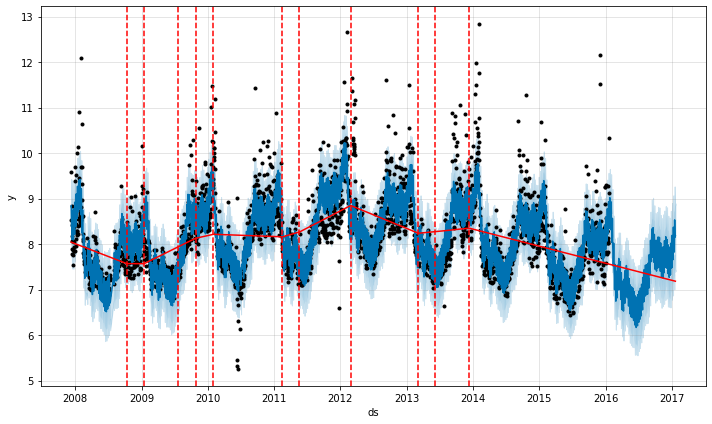

In [4]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

By default changepoints are only inferred for the first 80% of the time series in order to have plenty of runway for projecting the trend forward and to avoid overfitting fluctuations at the end of the time series. This default works in many situations but not all, and can be changed using the `changepoint_range` argument. For example, `m = Prophet(changepoint_range=0.9)` in Python or `m <- prophet(changepoint.range = 0.9)` in R will place potential changepoints in the first 90% of the time series.

### Adjusting trend flexibility
If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument `changepoint_prior_scale`. By default, this parameter is set to 0.05. Increasing it will make the trend *more* flexible:

Initial log joint probability = -19.4685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8043.87   0.000939651       386.682           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8076.18     0.0551794       704.264           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        8088.7    0.00449042       293.219           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8106.82    0.00302594       573.287      0.5531      0.5531      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8116.13    0.00365685       171.654           1           1      583   
    Iter      log prob        ||dx||      ||grad||       alpha  

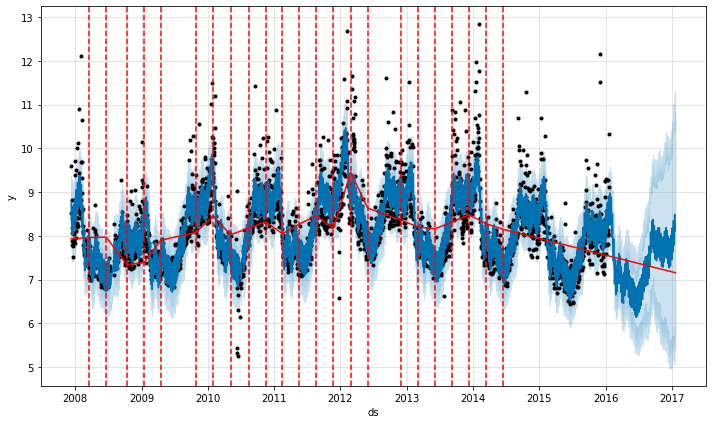

In [5]:
m = Prophet(changepoint_prior_scale=0.5)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

Decreasing it will make the trend *less* flexible:

Initial log joint probability = -19.4685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55        7632.2   0.000726144       3915.52   1.743e-07       0.001      114  LS failed, Hessian reset 
      95       7634.95   2.27594e-06       3624.51   7.026e-10       0.001      210  LS failed, Hessian reset 
      99       7634.95   1.98166e-07       2984.64      0.5015      0.5015      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       7634.95   7.29633e-09        3083.9      0.2256      0.5292      259   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


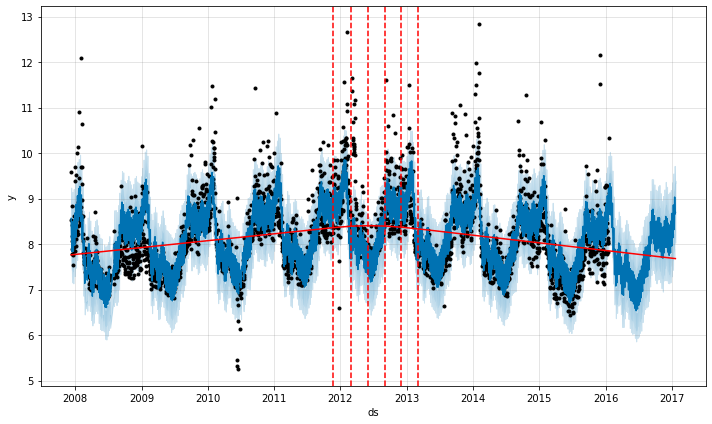

In [6]:
m = Prophet(changepoint_prior_scale=0.001)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

When visualizing the forecast, this parameter can be adjusted as needed if the trend seems to be over- or under-fit. In the fully-automated setting, see the documentation on cross validation for recommendations on how this parameter can be tuned.

### Specifying the locations of the changepoints

If you wish, rather than using automatic changepoint detection you can manually specify the locations of potential changepoints with the `changepoints` argument. Slope changes will then be allowed only at these points, with the same sparse regularization as before. One could, for instance, create a grid of points as is done automatically, but then augment that grid with some specific dates that are known to be likely to have changes. As another example, the changepoints could be entirely limited to a small set of dates, as is done here:

Initial log joint probability = -19.4685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      33       7794.72   3.30883e-05        2.5123      0.3682      0.9927       46   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


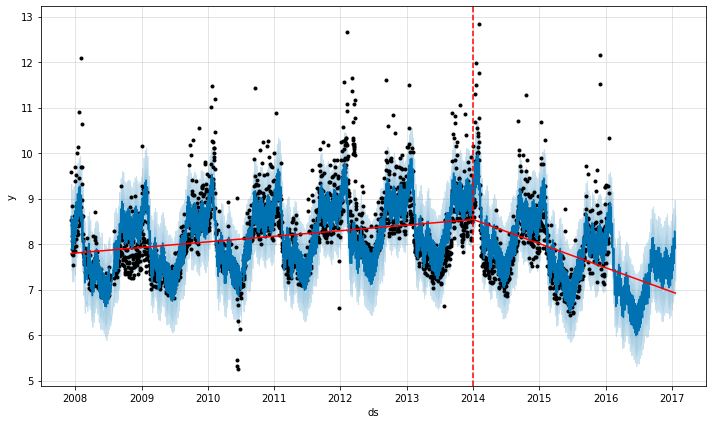

In [7]:
m = Prophet(changepoints=['2014-01-01'])
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)